In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from utils.make_classifier import *
import cv2
from glob import glob
import os
import re
from utils.transforms import *
from utils.make_dataset import *
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.utils.data as data
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import albumentations as A
import random
import shutil
import os
import time
from datetime import datetime
import argparse
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transform
import torch.nn.functional as F
#import warnings
#warnings.filterwarnings("ignore")
import model
from sklearn import preprocessing
from sklearn import metrics

with open("types_marking.json", "r") as read_file:
    new_data = json.load(read_file)

Populating the interactive namespace from numpy and matplotlib


In [2]:
PData = PreprocessedDatasetPart1()
data_list = PData.make_in_memory_dataset(task = 'bone marrow lesion', projection = 'cor',
                                         researh_types=['T1', 'PD', 'T2'], drop_types=['TRIM'],
                                         resize = False, best_slice = False, crop = False)


344  dataset length


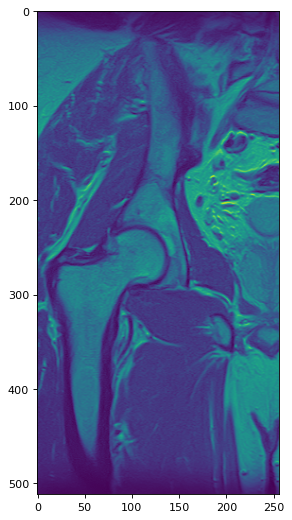

In [3]:
i = 1
img = data_list[i]['images'][data_list[i]['best_slice'] +1][0,:,:]
figure(figsize=(8, 8), dpi=80)
imgplot = plt.imshow(img)
plt.show()

In [4]:
BS_dataset = []


for item in data_list:    

    for i, img in enumerate(item['images']):    
        
        cl_item = {}
        
        if len(item['images'])<20:
            if i == item['best_slice']:
                
                cl_item['label'] = 1
            else:
                cl_item['label'] = 0
                
            cl_item['image'] = img[0,:,:]
            BS_dataset.append(cl_item)
            
        elif len(item['images'])<35:            
            if i in range(item['best_slice']-1, item['best_slice']+2):
                cl_item['label'] = 1
            else:
                cl_item['label'] = 0
            cl_item['image'] = img[0,:,:]
            BS_dataset.append(cl_item)
            
        elif len(item['images'])<60:
            
            if i in range(item['best_slice']-2, item['best_slice']+3):
                cl_item['label'] = 1
            else:
                cl_item['label'] = 0
            cl_item['image'] = img[0,:,:]
            BS_dataset.append(cl_item)
            
        elif len(item['images'])<100:            
            if i in range(item['best_slice']-4, item['best_slice']+5):
                cl_item['label'] = 1
            else:
                cl_item['label'] = 0
            cl_item['image'] = img[0,:,:]
            
            BS_dataset.append(cl_item)
            

In [5]:
del data_list

In [6]:
dim = (256,256)

interpolation = cv2.INTER_AREA
for item in BS_dataset:    
    
    #image = contrast_stretch(image)
    item['image'] = cv2.resize(item['image'], dim, interpolation)
    

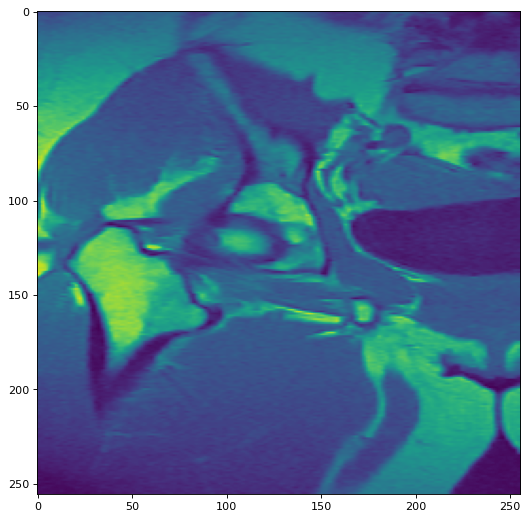

In [7]:
i = 1000
img = BS_dataset[i]['image']
figure(figsize=(8, 8), dpi=80)
imgplot = plt.imshow(img)
plt.show()

for key in list(new_data.keys()):
    element = {}
    label = new_data[key]
    path = key
    element['images'] = np.load(path, allow_pickle = True)
    element['label'] = label
    element['path'] = path
    data_list_im.append(element)  
    
len(data_list_im)

In [8]:
from sklearn.model_selection import train_test_split


means = []
stds = []
for img in subset(dataset):
    means.append(torch.mean(img))
    stds.append(torch.std(img))

mean = torch.mean(torch.tensor(means))
std = torch.mean(torch.tensor(stds))

In [9]:
class MRDatasetTypes(data.Dataset):

    def __init__(self,  train= True ):
        super().__init__()
        
      
        self.data = BS_dataset
        self.train = train
        self.length = len(BS_dataset)
        self.transform = transform
        if self.train:
            pass
        else:
            self.transform = False

        if self.transform:         

            self.transforms_random = A.Compose([
                A.HorizontalFlip(),
                A.RandomCrop(224, 224),
                A.Rotate(limit=5),
                
                #A.CLAHE(),
                A.GaussNoise(var_limit=(0.0, 30.0)),
                A.MedianBlur(blur_limit=3),
                #A.ElasticTransform(alpha=1, sigma=50),
                A.RandomGamma(gamma_limit=(60, 140)),
                #A.RandomFog(fog_coef_lower=0.0, fog_coef_upper=0.3)
            ])       
            
        weights = None
        
        if weights is None:
            pos = np.sum([d['label'] for d in  self.data])
            neg = len(self.data) - pos
            self.weights = torch.FloatTensor([1, neg / pos])
        else:
            self.weights = torch.FloatTensor(weights)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):  
        
        array = self.data[index]['image']
        array = np.stack((array, array,array), axis=-1)
        
        array = normalize_images_v1(array)
        label = self.data[index]['label']       
        if label == 0:
            label = torch.FloatTensor([[1, 0]])
        else:
            label = torch.FloatTensor([[0, 1]])     

        if self.transform:
            array = self.make_random_transforms(array, self.transforms_random)
        else:
            array = torch.from_numpy(array)

        return array, label, self.weights

    def make_random_transforms(self, image, random_transforms):       
        transformed = random_transforms(image=image)
        image = np.moveaxis(transformed["image"], -1, 0)
        return image

In [10]:
np.array([])

array([], dtype=float64)

In [ ]:
def train_model(model, train_loader, epoch, num_epochs, optimizer, current_lr, log_every = 60, batch_size = 1):
    _ = model.train()

    if torch.cuda.is_available():
        model.cuda()
        
    y_preds = np.array([])
    y_trues = np.array([])
    losses = []

    for i, (image, label, weights) in enumerate(train_loader):

       
        y_trues = np.concatenate((y_trues, label.numpy()[:,0,1]), axis=0) 
        
        
        optimizer.zero_grad()
        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weights = weights.cuda()

        label = torch.squeeze(label) 
        #print(label[0].cpu())      
        #figure(figsize=(8, 8), dpi=80)
        #imgplot = plt.imshow(image[0,0,:,:].cpu())
        #plt.show()
        prediction = model.forward(image.float())
        loss = torch.nn.BCEWithLogitsLoss(weight=weights)(prediction, label)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        losses.append(loss_value)
        probas = torch.sigmoid(prediction)
        
        y_pred = np.argmax(probas.detach().cpu().numpy(),axis = 1)
        y_preds = np.concatenate((y_preds, y_pred), axis=0)

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        if i >= 2:            
            acc = metrics.accuracy_score(y_trues, y_preds)
            acc = np.round(acc, 4)
        else:
            
            acc = '-'


        if (i % log_every == 0) & (i > 0):
            print('''[Epoch: {0} / {1} |Batch number : {2} / {3} ]| avg train loss {4} | train auc : {5} acc: {6} | lr : {7}'''.
                  format(
                      epoch + 1,
                      num_epochs,
                      i,
                      len(train_loader),
                      np.round(np.mean(losses), 4),
                      np.round(auc, 4),
                      acc,
                      current_lr
                  )
                  )

    train_loss_epoch = np.round(np.mean(losses), 4)
    train_auc_epoch = np.round(auc, 4)
    train_acc_epoch = acc
    return train_loss_epoch, train_auc_epoch, train_acc_epoch


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def run(lr_scheduler ='step',gamma = 0.5,epochs = 500,lr = 3e-6,
    log_every = 60, load_path = None, batch_size = 1):
    file_name = 'BS_classifier_rnx.pth'
    best_acc = 0.87
    now = datetime.now()
    train_dataset = MRDatasetTypes()
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
    
    

    mrnet = model.ResNext()

    if load_path != None:
        mrnet.load_state_dict(torch.load(load_path))

    if torch.cuda.is_available():
        mrnet = mrnet.cuda()

    optimizer = optim.Adam(mrnet.parameters(), lr=lr, weight_decay=0.1)

    if lr_scheduler == 'step':
        scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=3, gamma=gamma)

    
   
    num_epochs = epochs
    iteration_change_loss = 0
   

    t_start_training = time.time()
    epoch_delta = 0
    for epoch in range(num_epochs):
        current_lr = get_lr(optimizer)
        epoch_delta +=1
        t_start = time.time()
        
        train_loss, train_auc, train_acc = train_model(
            mrnet, train_loader, epoch, num_epochs, optimizer, current_lr, log_every, batch_size)
        if lr_scheduler == 'step':
            scheduler.step()

        t_end = time.time()
        delta = t_end - t_start

        print("train loss : {0} | train auc {1}  train acc {2}|  elapsed time {3} s".format(
            train_loss, train_auc, train_acc, delta))
        iteration_change_loss += 1
        print('-' * 30)
        if train_acc > best_acc:        
            torch.save(mrnet.state_dict(), f'./models/{epoch}_{file_name}')
            
    t_end_training = time.time()
    print(f'training took {t_end_training - t_start_training} s')

transform_flag = True
resize_flag = True

run(lr_scheduler ='step',gamma = 0.88,epochs = 1000,lr = 3e-6,
    log_every = 5, load_path = None, batch_size = 30)

[Epoch: 1 / 1000 |Batch number : 5 / 344 ]| avg train loss 3.0199 | train auc : 0.5366 acc: 0.5667 | lr : 3e-06
[Epoch: 1 / 1000 |Batch number : 10 / 344 ]| avg train loss 3.0049 | train auc : 0.4366 acc: 0.5545 | lr : 3e-06
[Epoch: 1 / 1000 |Batch number : 15 / 344 ]| avg train loss 2.9709 | train auc : 0.4487 acc: 0.5812 | lr : 3e-06
[Epoch: 1 / 1000 |Batch number : 20 / 344 ]| avg train loss 2.9244 | train auc : 0.4629 acc: 0.6206 | lr : 3e-06
[Epoch: 1 / 1000 |Batch number : 25 / 344 ]| avg train loss 2.8945 | train auc : 0.4479 acc: 0.6295 | lr : 3e-06
[Epoch: 1 / 1000 |Batch number : 30 / 344 ]| avg train loss 2.8679 | train auc : 0.4511 acc: 0.6538 | lr : 3e-06
[Epoch: 1 / 1000 |Batch number : 35 / 344 ]| avg train loss 2.8398 | train auc : 0.4543 acc: 0.6778 | lr : 3e-06
[Epoch: 1 / 1000 |Batch number : 40 / 344 ]| avg train loss 2.817 | train auc : 0.4548 acc: 0.6935 | lr : 3e-06
[Epoch: 1 / 1000 |Batch number : 45 / 344 ]| avg train loss 2.7863 | train auc : 0.4602 acc: 0.713

In [ ]:
subset = []
for item in BS_dataset:
    if item['label'] == 1:
        subset.append(item)

In [ ]:
import random 

PATH = 'models/3_BS_classifier_rnx.pth'

#item = random.choice(BS_dataset)


    
item = random.choice(subset)
print(item['label'])      
figure(figsize=(8, 8), dpi=80)
imgplot = plt.imshow(item['image'])
plt.show()

image = np.stack((item['image'], item['image'],item['image']), axis=-1)

image = np.moveaxis(image, -1, 0)
image = torch.tensor(np.expand_dims(image, axis=0)) 

#mrnet = model.MobileNetV3()
mrnet = model.ResNext()

mrnet.load_state_dict(torch.load(PATH))
mrnet.eval()

prediction = mrnet.forward(image.float())
sig = torch.nn.Sigmoid()
arr = sig(prediction).detach().numpy()
arr